In [2]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")

# Solution to Exercise 3 (Nov. 11, 2021)
---

# Zero-offset profiling

<img src="https://fwagner.info/lehre/updated_fig.png" style="width: 70%;">

A zero-offset seismic depth sounding is conducted with the aim of detecting the subsurface topography of a bedrock, overlain with sediments (see figure above). The surface is located at $z = 0$, and measurements are conducted in equidistant intervals (positions $x_b$).

A simplified seismic model view is assumed: A seismic signal is generated at a source location and the signal is then assumed to travel downwards and reflected at the top of the bedrock. A receiver at the source location then picks up the reflected signal. Measurements are thus travel times (in seconds of the seismic wave from source to bedrock and back $\rightarrow$ TWT, Two-way traveltimes). The P-wave velocity of the sediment layer is assumed to be $v = 2500$ m/s.

A transect of $100$ m length is measured, starting a $x=0$, ending at $x=100$ m. Measurements are equally spaced (with $N_d$ the number of measurements - changes depending on the subtask). The bedrock topography in reality is continuous ($z$); however, for the sake of simplicity (and applicability), assume a finite number of bedrock segments, with a constant depth for each segment ($z_b$) as model parameters.

### a) Describe the model parameters, data parameters, and auxiliary variables and their units. Under which circumstances is the problem unique, over-, mixed-, or under-determined?

**Solution**:

* **Model parameters**: model parameters are the bedrock depths at certain segments of the discretized bedrock topography. Measured in meters.
* **Data parameters**: $d$ are the measurements are thus travel times of the seismic wave from source to bedrock and back (TWT, Two-way traveltimes) measured seconds.
* **Auxiliary variables**: Auxiliary variables are geometry defintion, i.e. measurement locations, and the velocity of the upper layer, since both are needed to formulate $\mathbf{G}$.
---

* **Even-determined or unique $[N=M]$**: Exactly enough data available to determine the model parameters. At  every measurement location we have one measurement.
* **Over-determined $[N>M]$**: More than enough data available to determine the model parameters.
* **Under-determined $[N<M]$**: Insufficient data available to determine the model parameters. At some measurement locations, there is imply no information.
* **Mixed-determined**: More than enough data available to determine some of the model parameters, but insufficient data available to determine other model parameters.

### b) Uniquely-determined problem

Formulate the linear inverse problem for the *unique* (also known as even-determined) problem, given 10 equally-spaced measurements. Adjust the number of bedrock segments accordingly.

**Estimate the bedrock topography** for the following data & measurement positions:

In [3]:
import data
d = data.get_data() # Importing the measured data
x_b = np.linspace(0, 100, 10) # Creating mesurement positions
d, x_b

(array([0.00491314, 0.00343885, 0.00408858, 0.00435696, 0.00375178,
        0.00261924, 0.00205868, 0.00250247, 0.00274555, 0.00142059]),
 array([  0.        ,  11.11111111,  22.22222222,  33.33333333,
         44.44444444,  55.55555556,  66.66666667,  77.77777778,
         88.88888889, 100.        ]))

In addition to the data and measurements we know the seismic velocity $v = 2500$, e.g. from borehole measurements. From these parameters, we try to estimate $z_b$. Perform the inversion by setting up a G matrix and using the appropriate mathematical solution (hint: diagonal matrices can be created conveniently by first creating an [identity matrix](https://numpy.org/doc/stable/reference/generated/numpy.eye.html))

Plot the resulting (discrete) topography using the `plt.step` [function](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.step.html) (with the argument `where="mid"`). Also have a look at the [axhline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axhline.html) and [vlines](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.vlines.html) functions to plot the earth surface and the raypaths. Compare it to the true topography, which you can obtain via `data.get_true_topography()`.

**Solution**: 

The two-way travel time is:

$$t = -\frac{2}{v} \, z$$

accordingly, $\mathbf{G}$ can be formulated

$$
\underbrace{
\begin{pmatrix}
t_1\\
\vdots\\
t_{10}
\end{pmatrix}
}_{d \;(10 \times 1)}
=
\underbrace{
\begin{pmatrix}
-\frac{2}{v} & & \\
& \ddots & \\
& & -\frac{2}{v}
\end{pmatrix}
}_{\mathbf{G} \;(10 \times 10)}
\underbrace{
\begin{pmatrix}
z_1\\
\vdots\\
z_{10}
\end{pmatrix}
}_{\mathbf{m} \;(10 \times 1)}
$$

as an even-determined problem, it is solved by

$$\mathbf{m}_\mathrm{est} = \mathbf{G}^{-1} \mathbf{d}$$


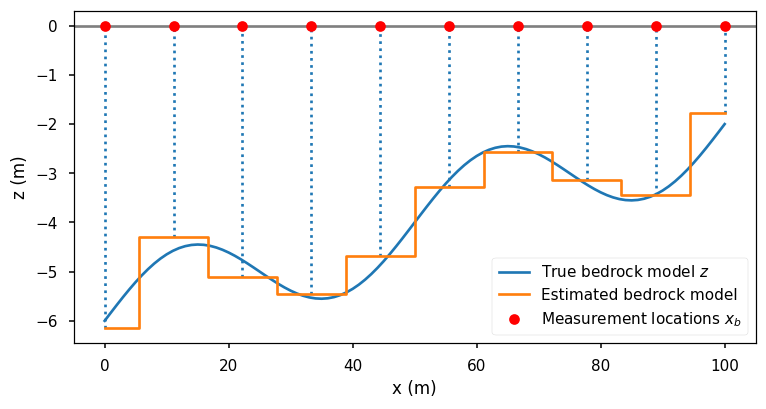

In [4]:
v = 2500
G = np.eye(10) * -2/v
mest = inv(G) @ d

x, z = data.get_true_topography() # Getting true bedrock for plotting purposes

plt.figure(dpi=110, figsize=(8,4))
plt.axhline(0, ls="-", c="k", alpha=0.5)
plt.plot(x, z, label="True bedrock model $z$")
plt.step(x_b, mest, where="mid", label="Estimated bedrock model")
plt.plot(x_b, np.zeros_like(x_b), "ro", label="Measurement locations $x_b$")
plt.vlines(x_b, mest, 0, linestyles="dotted")
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.legend()

### c) Damping

Now assume an under-determined problem, with only 4 measurements and 10 bedrock segments (i.e., model parameters). Estimate the bedrock depth for the sparse data set using the **damped-least squares solution** (often used for mixed-determined problems). Remember to keep the number of parameters (of the bedrock depth) the same as in (b). You can use the code snippet below to only use a subset of the data from task b (and also just a subset of rows in $\mathbf{G}$):

``` python
x_b_sparse = x_b[::3] # every third measurement location
d_sparse = d[::3] # every third measurement
```

Use damping constraints ($\mathbf{W}_m = I$) to solve the least-squares problem. Vary the regularization parameter between $10^{-10}$ and $1$ and describe the results. Which value would you choose? Plot the final bedrock estimation.

**Solution**:

$$
\mathbf{m}_\mathrm{est} = [\mathbf{G}^T \mathbf{G} + \beta \, \mathbf{I}]^{-1} \, \mathbf{G}^T \mathbf{d}
$$

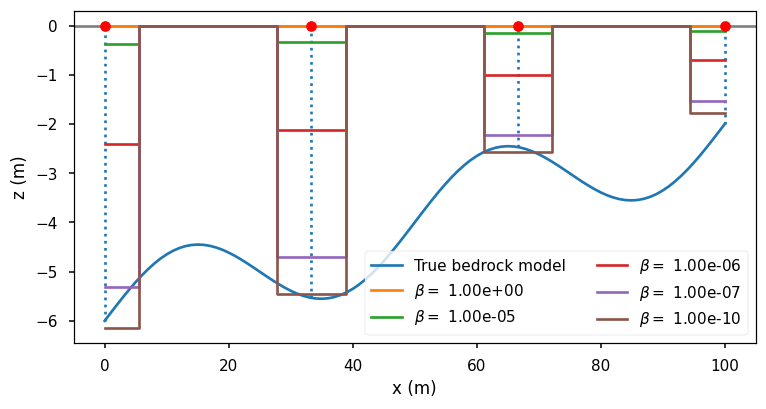

In [7]:
x_b_s = x_b[::3]
d_s = d[::3]
G_s = G[::3]
I = np.eye(G_s.shape[1])

plt.figure(figsize=(8,4), dpi=110)
plt.axhline(0, ls="-", c="k", alpha=0.5)
plt.plot(x, z, label="True bedrock model")

for beta in 1, 1e-5, 1e-6, 1e-7, 1e-10:
    G_g = np.linalg.inv(G_s.T @ G_s + beta * I) @ G_s.T
    m_est_s = G_g @ d_s
    plt.step(x_b, m_est_s, where="mid", label=r"$\beta =$ %.2e" % beta)

z_b = data.get_true_model() # Getting true, discrete bedrock model for plotting purposes only

plt.plot(x_b_s, np.zeros_like(x_b_s), "ro")
plt.vlines(x_b[::3], z_b[::3], 0, linestyles="dotted")
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.legend(ncol=2)

What happens if the damping factor is zero?

**Solution:** The solution reduces to the least-squares solution and the problem is not solvable anymore.

---
### Bonus question:

Compare the result of the damped least-squares solution (with a small damping factor) to the minimum-norm solution.

**Solution:** The damped-least squares solution with a low damping factor is equal to the minimum-norm solution.

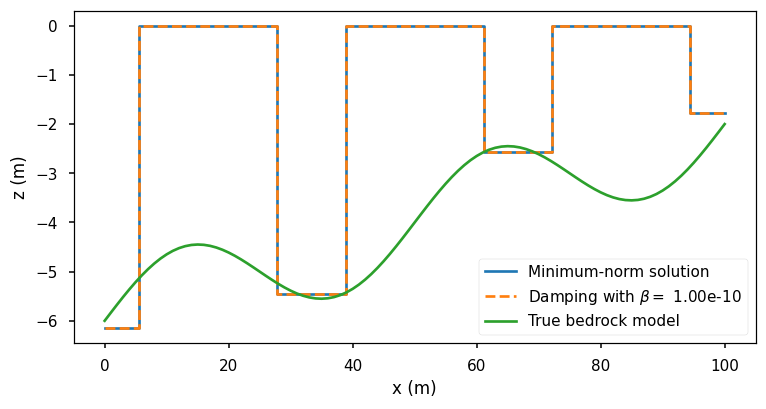

In [5]:
m_est_u = G_s.T @ np.linalg.inv(G_s @ G_s.T) @ d_s

plt.figure(figsize=(8,4), dpi=110)
plt.step(x_b, m_est_u, where="mid", label="Minimum-norm solution")
plt.step(x_b, m_est_s, ls="--", where="mid", label=r"Damping with $\beta =$ %.2e" % beta)
plt.plot(x, z, label="True bedrock model")
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.legend()